# Tutorial 11a: Extended Source Modeling

This tutorial demonstrates how to use the `ExtendedSourceOptic` feature to model extended sources in Optiland. 
We will simulate the irradiance profile of a beam shaping singlet with a collimated Gaussian extended source.

Key concepts covered:
1. Defining a custom optical system.
2. Setting up an extended source using `SMFSource` (Single-Mode Fiber Source).
3. Integrating the source with the optical system using `ExtendedSourceOptic`.
4. Visualizing the system with source rays.
5. Analysing the output irradiance.

In [1]:
import optiland.backend as be
from optiland.optic import Optic, ExtendedSourceOptic
from optiland.sources import SMFSource
from optiland.analysis import IncoherentIrradiance
from optiland.physical_apertures import RectangularAperture

## 1. Define the Optical System

First, we define the Beam Shaping Singlet system. This system is designed to transform a Gaussian beam into a flat-top profile.

In [2]:
gaussian_beam_waist = 5.0  # in mm
wavelength_um = 0.55  # in µm

# Forbes QBFS surface parameters
forbes_terms = {
    0: 0.5414,
    1: 0.6689,
    2: 0.3409,
    3: -0.0537,
    4: -0.3960,
    5: -0.2991,
    6: 0.3921,
}
forbes_norm_radius = 30.3636
top_hat_radius = 25.0

# Create the Optic
lens = Optic()
lens.set_aperture(
    aperture_type="EPD", value=gaussian_beam_waist * 6
)
lens.add_wavelength(value=wavelength_um, is_primary=True)
lens.set_field_type(field_type="angle")
lens.add_field(y=0.0)

# Add surfaces
lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(
    index=1,
    thickness=20.0,
    is_stop=True,
    aperture=RectangularAperture(
        x_min=-15,
        x_max=15,
        y_min=-15,
        y_max=15,
    ),
)
lens.add_surface(
    index=2,
    surface_type="forbes_qbfs",
    radius=5.7410,
    conic=-2.3165,
    thickness=15.0,
    material="N-BK7",
    radial_terms=forbes_terms,
    norm_radius=forbes_norm_radius,
    aperture=30.0,
)
lens.add_surface(
    index=3, 
    surface_type="standard", 
    radius=be.inf, 
    thickness=70.0, 
    material="air"
)
lens.add_surface(
    index=4,
    aperture=RectangularAperture(
        x_min=-top_hat_radius * 1.1,
        x_max=top_hat_radius * 1.1,
        y_min=-top_hat_radius * 1.1,
        y_max=top_hat_radius * 1.1,
    ),
)

## 2. Setup Extended Source

We use `SMFSource` to represent a collimated Gaussian source. 

**Note on Collimation:** To approximate a collimated source using `SMFSource`, we set the divergence angle to an extremely small value (e.g., `1e-10` degrees).
The Mode Field Diameter (MFD) determines the spatial extent of the beam. Here we set it to $2 × \text{waist} = 10\text{ mm} = 10000\text{ µm}$.

In [3]:
# MFD is in microns. 2 * waist (5mm) = 10mm = 10000um
mfd_microns = gaussian_beam_waist * 2 * 1000

# Create the source
source = SMFSource(
    mfd_um=mfd_microns,
    wavelength_um=wavelength_um,
    divergence_deg_1e2=1e-10,  # Virtually zero divergence for collimation
    total_power=1.0,
    position=(0, 0, 0)
)

# Wrap the optic with the source
ext_optic = ExtendedSourceOptic(lens, source)

print(source)

SMFSource(mfd=10000.0µm, divergence=1e-10°, wavelength=0.55µm, power=1.0W, mode=extended, position=(0.0, 0.0, 0.0))


## 3. Visualization

We can now draw the optical system with the source rays traced through it. The `draw` method of `ExtendedSourceOptic` handles this automatically.

C:\Users\Manuel\AppData\Local\Temp\ipykernel_39928\284778195.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


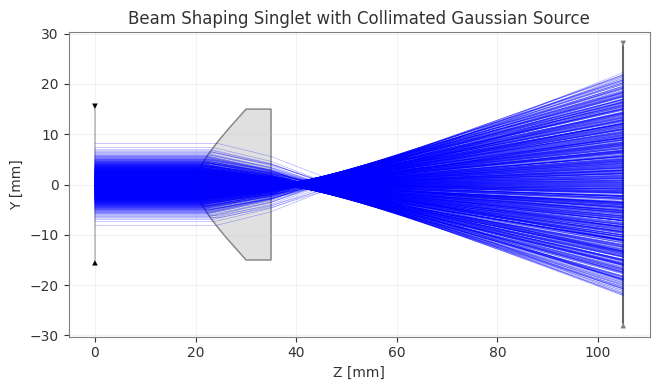

In [4]:
fig, ax = ext_optic.draw(num_rays=1000, title="Beam Shaping Singlet with Collimated Gaussian Source")
fig.show()

## 4. Irradiance Analysis

Finally, we calculate and visualize the irradiance at the image plane. We trace a larger number of rays for better resolution and use `IncoherentIrradiance`.

(<Figure size 600x500 with 1 Axes>,
 array([[<Axes: title={'center': '(User Rays: 0.0)'}, xlabel='X (mm)', ylabel='Irradiance (W/mm$^2$)'>]],
       dtype=object))

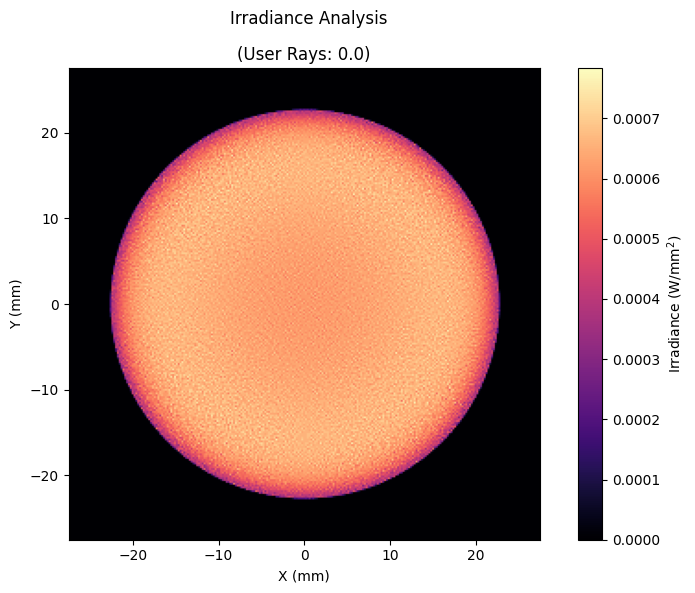

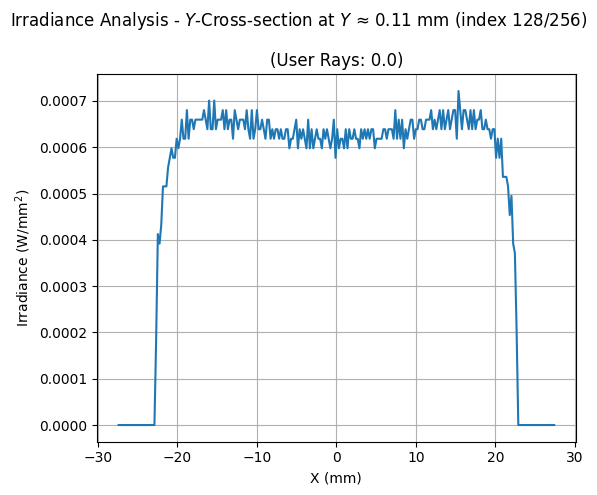

In [6]:
# Compute and plot irradiance
analysis = IncoherentIrradiance(lens, source=source, num_rays=1_000_000, detector_surface=-1, res=(256, 256))
analysis.view(figsize=(8, 6), cmap="magma", normalize=False)
analysis.view(cross_section=("cross-y", 128), normalize=False)